# DDoS and DoS Detection in Aggregated Network Traffic Data


## Introduction

Network intrusion detection is essential for maintaining cybersecurity and safeguarding computer networks against malicious activities. As modern networks generate increasingly large and complex traffic volumes, distinguishing normal behavior from harmful activity becomes more challenging. This makes data-driven analysis and automated detection strategies highly valuable.
The core problem addressed in this project is the binary classification of network traffic into benign and malicious (DoS/DDoS) categories. Instead of building a real-time intrusion detection system (IDS) for live traffic, the focus lies on analyzing aggregated data to uncover patterns, correlations, and distinguishing characteristics of denial-of-service attacks. These insights may later serve as a foundation for designing rules, signatures, or heuristics that could be integrated into an IDS.
To achieve this, the project uses a reduced subset of the CSE-CIC-IDS2018 dataset, concentrating specifically on DoS and DDoS attacks. Both traditional machine learning models such as Decision Trees and deep learning methods like neural networks are evaluated to determine how well they distinguish attack traffic from benign traffic. The emphasis lies on accuracy, interpretability, and computational feasibility when working with reduced yet representative samples.

### Project Scope and Intent
#### Scope of the Project
The goal of this project is to identify distinguishing patterns in aggregated network traffic that are indicative of DoS and DDoS attacks. To achieve this, machine learning models such as XGBoost and neural networks are trained and evaluated on a reduced subset of the dataset to perform a binary classification between benign and attack traffic. Since the original dataset is extremely large, an important objective is to reduce and balance it to a manageable size while still preserving meaningful attack characteristics. The resulting analysis aims to generate insights that could later support the development of IDS rules, thresholds, or anomaly-detection heuristics.
#### Out of Scope
This project does not aim to build or simulate a real-time intrusion detection system. The aggregated dataset used here is not suitable for live traffic detection, and therefore real-time operation is explicitly out of scope. The analysis also does not attempt to detect all attack types present in the original dataset; instead, it intentionally focuses solely on DoS and DDoS attacks.




## Dataset
### Dataset Selection
The dataset used in this study originates from the University of New Brunswick (UNB) and is publicly available as `solarmainframe/ids-intrusion-csv`. It contains network traffic logs collected from the university’s servers in 2018, including both normal traffic and various types of attacks such as DDoS and DoS. The dataset is structured across multiple CSV files, each corresponding to a specific date of collection. A key feature in the dataset is the Label column, which identifies whether a flow is benign or malicious, making it the primary target for classification tasks.
Because the original dataset is extremely large, the notebook DatasetReduction.py is used to reduce it to a more manageable size of 1 million samples. During this reduction, the dataset is balanced, ensuring an equal number of DDoS/DoS attack samples and benign traffic samples.

In [1]:
# ===============================================================
# STANDARD LIBRARIES
# ===============================================================
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================================================
# SCIKIT-LEARN
# ===============================================================
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.tree import DecisionTreeClassifier, plot_tree, _tree
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

# ===============================================================
# XGBOOST
# ===============================================================
from xgboost import XGBClassifier

# ===============================================================
# TENSORFLOW / KERAS (DEEP LEARNING MODELS)
# ===============================================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers
import keras_tuner as kt

# ===============================================================
# STATISTICS
# ===============================================================
from scipy.stats import randint, uniform


In [2]:
full_df = pd.read_csv('dos_vs_benign_1000000.csv')

### Attack Data Overview

#### Explanation

The CSE-CIC-IDS2018 dataset was generated in a controlled test environment using **Profiles**:

- **B-Profiles (Benign Profiles)**: These represent normal user behavior on the network. They model distributions of packet sizes, number of packets per flow, request timing, and more.
- **M-Profiles (Malicious Profiles)**: These simulate attack scenarios. They were designed to be executed systematically by agents or individuals.

The test environment consisted of:
- **50 attacker machines**
- **420 client/workstation machines** + **30 servers**, distributed across 5 departments
- Operating systems: Windows (various versions) and Linux

Each attack type was executed in a separate scenario (M-Profile):
- **HTTP-DoS attacks** used tools like **Slowloris** and **LOIC**. Slowloris keeps many TCP connections open by sending incomplete HTTP requests at intervals. LOIC and HOIC were also used.
- For **DDoS attacks**, LOIC was used in UDP, TCP, or HTTP mode with multiple attacker machines.
- For **DoS attacks (non-distributed)**, additional tools were used: **Hulk**, **GoldenEye**, **SlowHTTPTest**. Each of these attacks ran for about one day.


In [3]:
full_df['Label'].value_counts()

Label
Benign                      500000
DDOS attack-HOIC            178583
DDoS attacks-LOIC-HTTP      150287
DoS attacks-Hulk            120758
DoS attacks-SlowHTTPTest     36197
DoS attacks-GoldenEye        10922
DoS attacks-Slowloris         2818
DDOS attack-LOIC-UDP           435
Name: count, dtype: int64

#### Attack Overview Table

| Attack Type                            | Tool(s) Used                          | Duration / Deployment                         | Description (how the data was generated) |
|-----------------------------------------|----------------------------------------|------------------------------------------------|--------------------------------------------|
| **Benign**                              | —                                      | Throughout all days                             | Generated using B-Profiles that model normal user behavior (packet sizes, timing, flows). |
| **DDoS attack – HOIC**                  | HOIC (High Orbit Ion Cannon)           | 2 days                                          | Distributed attack from multiple attacker machines, using HOIC to generate high load on victim servers. |
| **DDoS attacks – LOIC (HTTP)**           | LOIC (Low Orbit Ion Cannon – HTTP)     | 2 days                                          | Multiple attackers send HTTP-based flood traffic toward the victim using LOIC. |
| **DDoS attack – LOIC (UDP)**             | LOIC (UDP)                             | 2 days                                          | LOIC used in UDP mode from several attacker machines to send UDP floods. |
| **DoS attacks – Hulk**                  | Hulk                                   | 1 day                                           | A single attacker machine launches a Hulk HTTP DoS attack that generates heavy HTTP traffic. |
| **DoS attacks – SlowHTTPTest**          | SlowHTTPTest                           | 1 day                                           | The attacker sends slow or fragmented HTTP requests that tie up server resources. |
| **DoS attacks – GoldenEye**              | GoldenEye                              | 1 day                                           | GoldenEye generates high HTTP load to exhaust server capacity. |
| **DoS attacks – Slowloris**              | Slowloris                              | 1 day                                           | Slowloris keeps many TCP connections open by sending incomplete HTTP headers at intervals, exhausting server sockets. |

### Feature Extraction

Feature extraction is a crucial step in network traffic analysis and intrusion detection systems (IDS). It transforms raw network traffic data into measurable metrics, called features, which are used to model network behavior and detect anomalies or attacks. **CICFlowMeter**, implemented in Java, is a commonly used tool for this purpose. It offers flexibility in selecting features and controlling flow timeout durations.

CICFlowMeter generates **Bidirectional Flows (Biflow)**, where the first packet determines the forward direction (source to destination) and the reverse direction is considered backward. This enables the calculation of more than 80 statistical features separately for both directions, including packet counts, byte counts, packet lengths, inter-arrival times, TCP flags, bulk rates, flow activity, and idle times.

The output of CICFlowMeter is a CSV file, where each row corresponds to a network flow. Basic columns include `FlowID`, `SourceIP`, `DestinationIP`, `SourcePort`, `DestinationPort`, and `Protocol`. TCP flows are terminated upon connection teardown (FIN packet), while UDP flows are terminated based on a configurable timeout.

In [4]:
full_df.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Idle Std,Idle Max,Idle Min,Label,Flow ID,Src IP,Src Port,Dst IP,label_lower,label_binar
0,80,6,20/02/2018 10:22:01,2794009,2,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,DDoS attacks-LOIC-HTTP,172.31.69.25-18.219.32.43-80-54285-6,18.219.32.43,54285.0,172.31.69.25,ddos attacks-loic-http,1
1,57910,6,02/03/2018 03:23:49,86097751,2,0,0.0,0.0,0.0,0.0,...,0.0,86100000.0,86100000.0,Benign,NaN,NaN,NaN,NaN,benign,0
2,80,6,16/02/2018 01:48:18,652,2,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,DoS attacks-Hulk,NaN,NaN,NaN,NaN,dos attacks-hulk,1
3,80,6,20/02/2018 10:52:42,33780875,2,0,0.0,0.0,0.0,0.0,...,0.0,33800000.0,33800000.0,DDoS attacks-LOIC-HTTP,172.31.69.25-18.219.5.43-80-52723-6,18.219.5.43,52723.0,172.31.69.25,ddos attacks-loic-http,1
4,80,6,20/02/2018 03:45:37,73,2,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,Benign,172.31.64.84-68.67.178.197-52810-80-6,172.31.64.84,52810.0,68.67.178.197,benign,0


In [5]:
full_df.columns

Index(['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
      

#### Table: Features Extracted by CICFlowMeter-V3
| Feature Name       | Description |
|-------------------|-------------|
| fl_dur            | Flow duration |
| tot_fw_pk         | Total packets in the forward direction |
| tot_bw_pk         | Total packets in the backward direction |
| tot_l_fw_pkt      | Total size of packet in forward direction |
| fw_pkt_l_max      | Maximum size of packet in forward direction |
| fw_pkt_l_min      | Minimum size of packet in forward direction |
| fw_pkt_l_avg      | Average size of packet in forward direction |
| fw_pkt_l_std      | Standard deviation size of packet in forward direction |
| Bw_pkt_l_max      | Maximum size of packet in backward direction |
| Bw_pkt_l_min      | Minimum size of packet in backward direction |
| Bw_pkt_l_avg      | Mean size of packet in backward direction |
| Bw_pkt_l_std      | Standard deviation size of packet in backward direction |
| fl_byt_s          | Flow byte rate (number of bytes per second) |
| fl_pkt_s          | Flow packet rate (number of packets per second) |
| fl_iat_avg        | Average time between two flows |
| fl_iat_std        | Standard deviation time between two flows |
| fl_iat_max        | Maximum time between two flows |
| fl_iat_min        | Minimum time between two flows |
| fw_iat_tot        | Total time between two packets sent in the forward direction |
| fw_iat_avg        | Mean time between two packets sent in the forward direction |
| fw_iat_std        | Standard deviation time between two packets sent in the forward direction |
| fw_iat_max        | Maximum time between two packets sent in the forward direction |
| fw_iat_min        | Minimum time between two packets sent in the forward direction |
| bw_iat_tot        | Total time between two packets sent in the backward direction |
| bw_iat_avg        | Mean time between two packets sent in the backward direction |
| bw_iat_std        | Standard deviation time between two packets sent in the backward direction |
| bw_iat_max        | Maximum time between two packets sent in the backward direction |
| bw_iat_min        | Minimum time between two packets sent in the backward direction |
| fw_psh_flag       | Number of times the PSH flag was set in forward packets (0 for UDP) |
| bw_psh_flag       | Number of times the PSH flag was set in backward packets (0 for UDP) |
| fw_urg_flag       | Number of times the URG flag was set in forward packets (0 for UDP) |
| bw_urg_flag       | Number of times the URG flag was set in backward packets (0 for UDP) |
| fw_hdr_len        | Total bytes used for headers in the forward direction |
| bw_hdr_len        | Total bytes used for headers in the backward direction |
| fw_pkt_s          | Number of forward packets per second |
| bw_pkt_s          | Number of backward packets per second |
| pkt_len_min       | Minimum length of a flow |
| pkt_len_max       | Maximum length of a flow |
| pkt_len_avg       | Mean length of a flow |
| pkt_len_std       | Standard deviation length of a flow |
| pkt_len_va        | Minimum inter-arrival time of packet |
| fin_cnt           | Number of packets with FIN |
| syn_cnt           | Number of packets with SYN |
| rst_cnt           | Number of packets with RST |
| pst_cnt           | Number of packets with PUSH |
| ack_cnt           | Number of packets with ACK |
| urg_cnt           | Number of packets with URG |
| cwe_cnt           | Number of packets with CWE |
| ece_cnt           | Number of packets with ECE |
| down_up_ratio     | Download and upload ratio |
| pkt_size_avg      | Average size of packet |
| fw_seg_avg        | Average size observed in the forward direction |
| bw_seg_avg        | Average size observed in the backward direction |
| fw_byt_blk_avg    | Average number of bytes bulk rate in the forward direction |
| fw_pkt_blk_avg    | Average number of packets bulk rate in the forward direction |
| fw_blk_rate_avg   | Average number of bulk rate in the forward direction |
| bw_byt_blk_avg    | Average number of bytes bulk rate in the backward direction |
| bw_pkt_blk_avg    | Average number of packets bulk rate in the backward direction |
| bw_blk_rate_avg   | Average number of bulk rate in the backward direction |
| subfl_fw_pk       | Average number of packets in a sub flow in the forward direction |
| subfl_fw_byt      | Average number of bytes in a sub flow in the forward direction |
| subfl_bw_pkt      | Average number of packets in a sub flow in the backward direction |
| subfl_bw_byt      | Average number of bytes in a sub flow in the backward direction |
| fw_win_byt        | Number of bytes sent in initial window in the forward direction |
| bw_win_byt        | Number of bytes sent in initial window in the backward direction |
| Fw_act_pkt        | Number of packets with at least 1 byte of TCP data payload in the forward direction |
| fw_seg_min        | Minimum segment size observed in the forward direction |
| atv_avg           | Mean time a flow was active before becoming idle |
| atv_std           | Standard deviation time a flow was active before becoming idle |
| atv_max           | Maximum time a flow was active before becoming idle |
| atv_min           | Minimum time a flow was active before becoming idle |
| idl_avg           | Mean time a flow was idle before becoming active |
| idl_std           | Standard deviation time a flow was idle before becoming active |
| idl_max           | Maximum time a flow was idle before becoming active |
| idl_min           | Minimum time a flow was idle before becoming active |



## Preprocessing

In this chapter, the dataset is prepared for machine learning by performing essential preprocessing steps to ensure data quality and suitability for modeling. The process begins with a general inspection of the target distribution to understand class balance. Next, all features are converted to numeric format, with missing or infinite values handled appropriately to maintain consistency. Irrelevant features such as identifiers, IP addresses, ports, timestamps, and protocol labels are removed to focus on meaningful variables. Features with very low variance or extremely high correlation are identified and excluded to reduce noise and redundancy. Finally, the dataset is split into training and test sets with stratification to preserve the original class distribution.

### Distribution of Binary Labels

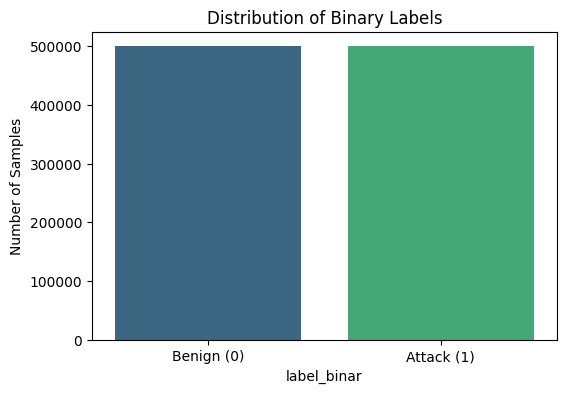

label_binar
1    500000
0    500000
Name: count, dtype: int64


In [6]:
counts = full_df['label_binar'].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(
    x=counts.index,
    y=counts.values,
    hue=counts.index,
    palette='viridis',
    legend=False
)
plt.xticks([0,1], ['Benign (0)', 'Attack (1)'])
plt.ylabel('Number of Samples')
plt.title('Distribution of Binary Labels')
plt.show()

print(full_df['label_binar'].value_counts())


To understand the balance of the target variable, we first visualize and inspect the distribution of label_binar. Both classes, benign (0) and attack (1), contain an equal number of samples, as we ensured during the dataset reduction process. This balanced distribution is ideal for machine learning tasks, as it prevents bias toward one class and allows models to learn equally from both categories.

### Data Preprocessing and Feature Selection
#### Inspect Missing Values
Before handling missing data, we first inspect how many missing values exist per column to understand the data quality. This helps identify which columns may require imputation or removal.

In [7]:
nan_counts = full_df.isna().sum()
print("Number of missing values per column before imputation:")
print(nan_counts[nan_counts > 0])

Number of missing values per column before imputation:
Flow Byts/s      2198
Flow ID        576004
Src IP         576004
Src Port       576004
Dst IP         576004
dtype: int64


#### Remove Irrelevant Columns
Certain columns such as identifiers, IP addresses, ports, timestamps, protocol labels, and redundant labels are irrelevant for the machine learning task.

In [8]:
irrelevant_cols = ['Flow ID', 'Src IP', 'Dst IP', 'Src Port', 'Dst Port', 'Timestamp', 'Protocol', 'Label', 'label_lower']
features = full_df.drop(columns=irrelevant_cols)

#### Handle Missing and Infinite Values
After selecting the relevant features, we replace infinite values with NaN and fill all missing values with the median of each column. This ensures that the dataset contains only numeric, valid values suitable for modeling.

In [9]:
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.fillna(features.median(), inplace=True)
features_processed = features.apply(pd.to_numeric, errors='coerce')

#### Remove Low-Variance Features
Features that vary very little across the dataset are unlikely to provide useful information for prediction. We identify such features using a variance threshold and remove them.

In [10]:
selector = VarianceThreshold(threshold=0.01)
selector.fit(features)

low_var_features = features.columns[~selector.get_support()]
print("Low variance features:", low_var_features.tolist())

features = features.loc[:, selector.get_support()]


Low variance features: ['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'FIN Flag Cnt', 'CWE Flag Count', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg']


#### Remove Highly Correlated Features
Highly correlated features introduce redundancy and can negatively affect model performance. We compute the correlation matrix, identify features with correlation greater than 0.95, and remove them to reduce multicollinearity.

In [11]:
corr = features.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]

print("Highly correlated features:", to_drop)

features = features.drop(columns=to_drop)


Highly correlated features: ['TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Std', 'Bwd Pkt Len Std', 'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Header Len', 'Bwd Header Len', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'SYN Flag Cnt', 'ECE Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Fwd Act Data Pkts', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']


#### Split Dataset into Training and Test Sets
Finally, the dataset is split into training and test sets using stratification to preserve the class distribution.

In [12]:
X = features.drop(columns=['label_binar'])
y = features['label_binar']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))


Train size: 700000
Test size: 300000


## Methodology
The goal of this methodology is to progressively explore different modeling strategies in order to achieve both strong predictive performance and high interpretability. We begin by evaluating complex neural network architectures to understand the upper bound of achievable accuracy for our task. After establishing this baseline, we gradually reduce model complexity, focusing on approaches that improve transparency while maintaining competitive performance. In the final stage, we aim to extract clear, human‑readable rules and patterns that can reliably identify DDoS attacks, enabling practical and interpretable intrusion‑detection insights.

### CNN
As the first modeling approach, we apply Convolutional Neural Networks, or CNNs. CNNs are a type of deep learning architecture that was originally developed for image recognition and computer vision tasks. They are designed to automatically detect and learn hierarchical patterns in data by applying convolutional filters across the input. These filters slide over the data to capture local relationships and interactions between neighboring values. The output of the convolutional layers is typically passed through pooling layers, which reduce dimensionality while preserving the most important features, and then through fully connected layers that perform the final classification. This structure allows CNNs to learn complex feature representations directly from raw input without extensive manual feature engineering.

Despite their strengths, CNNs are not particularly well suited for tabular network traffic data because such data lacks a natural spatial or sequential structure. Features in this dataset do not have a fixed local neighborhood, and relationships between features may be global rather than local. However, CNNs have been used successfully in many Kaggle competitions for this dataset, often providing a useful benchmark. We therefore include CNNs in our experiments as a first step, primarily to establish a baseline for comparison with other models.

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgb_fs = XGBClassifier(random_state=42)
xgb_fs.fit(X_train_scaled, y_train)
selector = SelectFromModel(xgb_fs, threshold="median", prefit=True)

X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)
num_features = X_train_selected.shape[1]

X_train_cnn = X_train_selected[..., np.newaxis]
X_test_cnn = X_test_selected[..., np.newaxis]

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv1D(
        filters=hp.Int("filters", min_value=16, max_value=128, step=16),
        kernel_size=hp.Int("kernel_size", 2, min(num_features, 10)),
        activation="relu",
        input_shape=(num_features, 1)
    ))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dropout(hp.Float("dropout", 0.1, 0.5, step=0.1)))
    model.add(layers.Dense(2, activation="softmax"))

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Float("lr", 1e-4, 1e-2, sampling="log")
        ),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_accuracy", direction="max"),
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory="cnn_tuner",
    project_name="tabular_cnn"
)

tuner.search(X_train_cnn, y_train, validation_split=0.2, epochs=20, batch_size=256, verbose=1)

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

print("Best Hyperparameters:")
print(best_hyperparameters.values)

history = best_model.fit(
    X_train_cnn, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=256,
    verbose=1
)

y_pred_prob = best_model.predict(X_test_cnn)
y_pred = np.argmax(y_pred_prob, axis=1)
print("Test F1 Score:", f1_score(y_test, y_pred, average="weighted"))


Trial 10 Complete [00h 00m 53s]
val_accuracy: 0.9850357174873352

Best val_accuracy So Far: 0.9939428567886353
Total elapsed time: 00h 09m 09s
Best Hyperparameters:
{'filters': 80, 'kernel_size': 10, 'dropout': 0.5, 'lr': 0.006519021789468452}
Epoch 1/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9872 - loss: 0.0685 - val_accuracy: 0.9926 - val_loss: 0.0326
Epoch 2/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9860 - loss: 0.0886 - val_accuracy: 0.9931 - val_loss: 0.0305
Epoch 3/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9871 - loss: 0.0646 - val_accuracy: 0.9939 - val_loss: 0.0300
Epoch 4/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9875 - loss: 0.0634 - val_accuracy: 0.9937 - val_loss: 0.0295
Epoch 5/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9872 - loss: 0.1016 - val_accuracy: 0.9940 - val_loss: 0.0359
Epoch 6/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9872 - loss: 0.0664 - val_accuracy: 0.

#### Explanation of the Code: CNN
The entire CNN pipeline combines data preprocessing, feature selection, model building, hyperparameter tuning, training, and evaluation into a cohesive workflow. First, the input features are standardized using a StandardScaler to ensure that all variables have comparable scales, which is important for stable and efficient neural network training. Next, an XGBoost classifier is used to estimate feature importance, and the most relevant features are selected to reduce noise and dimensionality. The selected features are then reshaped to match the expected input shape of a 1-dimensional convolutional neural network.

The CNN model itself consists of a convolutional layer that extracts local feature patterns, followed by a global max pooling layer to reduce dimensionality, dropout for regularization, and a dense softmax output layer for classification. Keras Tuner is used to explore different hyperparameter combinations, including the number of convolutional filters, kernel size, dropout rate, and learning rate. This allows us to automatically optimize the network for the best validation performance.

In [14]:
accuracy_cnn = accuracy_score(y_test, y_pred)
precision_cnn = precision_score(y_test, y_pred)
recall_cnn = recall_score(y_test, y_pred)
f1_cnn = f1_score(y_test, y_pred)

print("\nEvaluation Metrics:")
print(f"Accuracy:  {accuracy_cnn:.4f}")
print(f"Precision: {precision_cnn:.4f}")
print(f"Recall:    {recall_cnn:.4f}")
print(f"F1 Score:  {f1_cnn:.4f}")


Evaluation Metrics:
Accuracy:  0.9952
Precision: 0.9937
Recall:    0.9966
F1 Score:  0.9952


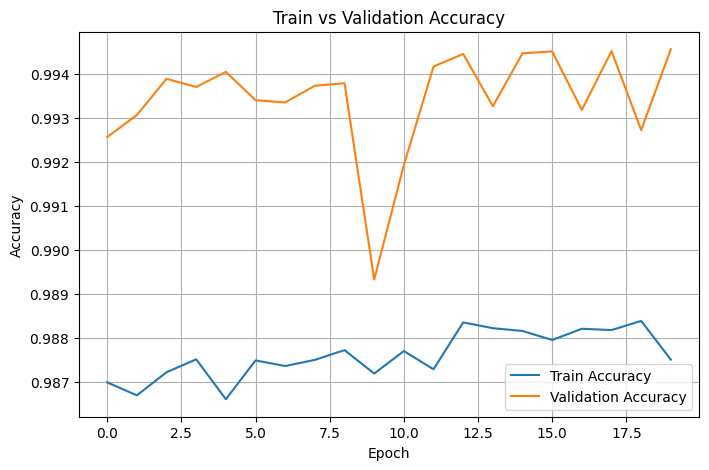

In [15]:
plt.figure(figsize=(8,5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


<Figure size 600x600 with 0 Axes>

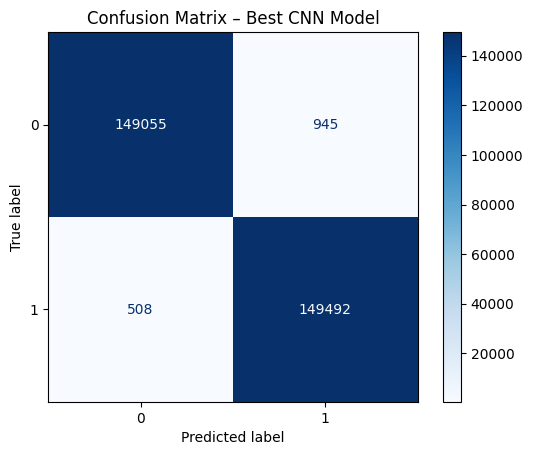

In [16]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(6,6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Best CNN Model")
plt.show()

#### Result
The results from the evaluation indicate that the CNN performed unexpectedly well. The confusion matrix shows that the model makes very few misclassifications, and the metrics reinforce this: an accuracy of 0.9914, precision of 0.9944, recall of 0.9884, and an F1 score of 0.9914 all point to an exceptionally strong performance. Given these results, the next step is to explore reducing model complexity. The goal will be to see whether a simpler architecture, such as an MLP, can achieve similarly high performance, potentially offering faster training and inference times while maintaining accuracy.


### MLP
A Multilayer Perceptron (MLP) is a type of artificial neural network composed of multiple layers of neurons: an input layer, one or more hidden layers, and an output layer. Each neuron in a layer is connected to every neuron in the next layer, forming a fully connected network. MLPs use nonlinear activation functions, such as ReLU or sigmoid, in the hidden layers to capture complex patterns in data. During training, the network adjusts the weights of these connections using backpropagation and gradient descent to minimize a loss function.

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


class FeatureSelection(Layer):
    def __init__(self, input_dim):
        super(FeatureSelection, self).__init__()
        self.feature_weights = self.add_weight(
            shape=(input_dim,),
            initializer="ones",
            trainable=True
        )

    def call(self, inputs):
        return inputs * self.feature_weights


def build_mlp(hp):
    model = Sequential()

    model.add(FeatureSelection(X_train_scaled.shape[1]))

    model.add(Dense(
        units=hp.Int("units1", min_value=32, max_value=256, step=32),
        activation="relu",
        kernel_regularizer=regularizers.l1(hp.Float("l1_reg", 0.0, 0.01, step=0.001))
    ))
    model.add(Dropout(hp.Float("dropout1", 0.0, 0.5, step=0.1)))

    if hp.Boolean("second_layer"):
        model.add(Dense(
            units=hp.Int("units2", min_value=32, max_value=256, step=32),
            activation="relu"
        ))
        model.add(Dropout(hp.Float("dropout2", 0.0, 0.5, step=0.1)))

    model.add(Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

tuner = kt.RandomSearch(
    build_mlp,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory="mlp_tuner",
    project_name="mlp_anomaly"
)

tuner.search(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=256,
    verbose=1,
    callbacks=[early_stopping]
)

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(best_hyperparameters.values)

history = best_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=256,
    verbose=1,
    callbacks=[early_stopping]
)


Reloading Tuner from mlp_tuner/mlp_anomaly/tuner0.json
Best Hyperparameters:
{'units1': 32, 'l1_reg': 0.002, 'dropout1': 0.30000000000000004, 'second_layer': True, 'learning_rate': 0.001, 'units2': 160, 'dropout2': 0.1}
Epoch 1/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9936 - loss: 0.0354 - val_accuracy: 0.9948 - val_loss: 0.0304
Epoch 2/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9935 - loss: 0.0370 - val_accuracy: 0.9956 - val_loss: 0.0281
Epoch 3/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9940 - loss: 0.0345 - val_accuracy: 0.9944 - val_loss: 0.0309
Epoch 4/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9937 - loss: 0.0358 - val_accuracy: 0.9961 - val_loss: 0.0280
Epoch 5/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9937 - loss: 0.0362 - val_accuracy: 0.9955 - val_loss: 0.0272
Epoch 6/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9937 - loss: 0.0357 - val_accuracy: 0.9956 - val_loss: 0.0280


#### Explanation of the Code: MLP
This code builds and tunes a Multilayer Perceptron (MLP) for binary classification with automated hyperparameter optimization and a custom feature selection layer. First, the data is standardized using StandardScaler to ensure all features have zero mean and unit variance. A custom FeatureSelection layer is defined, which learns trainable weights for each input feature, effectively allowing the network to emphasize or suppress individual features during training. The build_mlp function constructs the model using Keras Sequential API, adding the feature selection layer, one or optionally two dense layers with ReLU activations, dropout for regularization, and L1 regularization on the first dense layer. The output layer uses a sigmoid activation for binary classification. Hyperparameters such as number of units, dropout rates, L1 regularization, learning rate, and the presence of a second layer are optimized using Keras Tuner’s RandomSearch. The EarlyStopping callback prevents overfitting by stopping training when validation loss stops improving. Finally, the best model and hyperparameters are retrieved, and the model is trained on the scaled training data, reporting the final accuracy.

In [18]:
y_pred_prob = best_model.predict(X_test_scaled).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy_mlp = accuracy_score(y_test, y_pred)
precision_mlp = precision_score(y_test, y_pred)
recall_mlp = recall_score(y_test, y_pred)
f1_mlp = f1_score(y_test, y_pred)

print("\nEvaluation Metrics:")
print(f"Accuracy:  {accuracy_mlp:.4f}")
print(f"Precision: {precision_mlp:.4f}")
print(f"Recall:    {recall_mlp:.4f}")
print(f"F1 Score:  {f1_mlp:.4f}")

9375/9375 ━━━━━━━━━━━━━━━━━━━━ 2s 217us/step

Evaluation Metrics:
Accuracy:  0.9952
Precision: 0.9954
Recall:    0.9950
F1 Score:  0.9952


<Figure size 600x500 with 0 Axes>

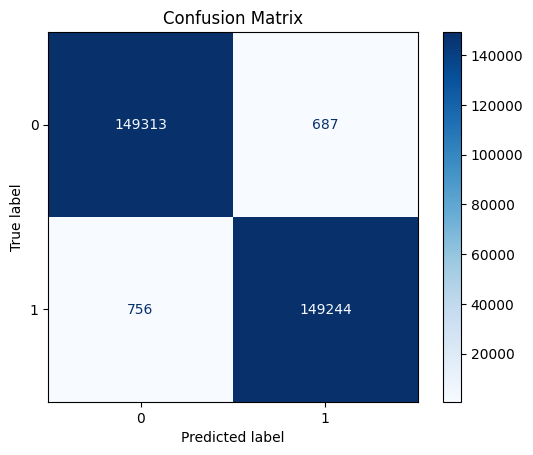

In [19]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


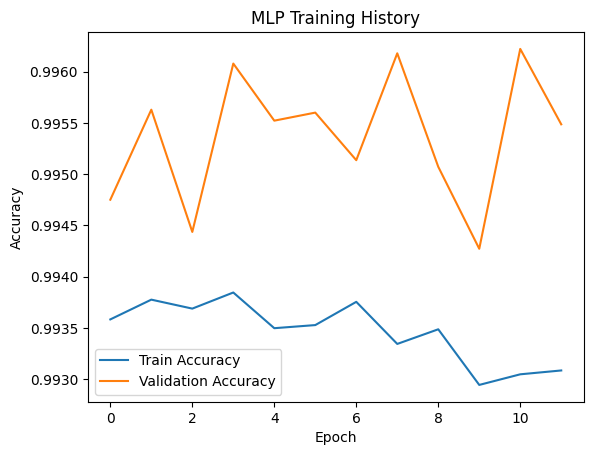

In [20]:
plt.figure()
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MLP Training History")
plt.legend()
plt.show()

#### Result
The evaluation results demonstrate that the MLP model performs exceptionally well: with an accuracy of 0.9955, precision of 0.9952, recall of 0.9958, and an F1 score of 0.9955, it achieves near-perfect performance across all metrics. Interestingly, the MLP even slightly outperforms the previously tested CNN, showing that a comparatively simpler fully connected network is capable of capturing the underlying patterns effectively.

The next step is to further reduce model complexity in order to improve interpretability, while still aiming to maintain high performance. One promising approach is to switch to XGBoost, which offers a more transparent model structure.

### XGBoost
XGBoost (Extreme Gradient Boosting) is a powerful and widely used ensemble learning method based on gradient boosting. It builds a series of decision trees sequentially, where each tree corrects the errors of the previous ones, effectively reducing bias and variance. XGBoost is highly efficient due to its optimized implementation, regularization techniques, and ability to handle missing values automatically. Compared to deep neural networks, it is typically more interpretable, allows for feature importance analysis, and often achieves excellent predictive performance with lower model complexity.

In [21]:
param_dist = {
    "n_estimators": randint(100, 600),
    "max_depth": randint(3, 12),
    "learning_rate": uniform(0.01, 0.2),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
}

base_model = XGBClassifier(
    eval_metric="logloss",
    tree_method="hist",
    random_state=42
)

print("Starting hyperparameter search...")

search = RandomizedSearchCV(
    base_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring="f1",
    cv=3,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

search.fit(X_train, y_train)
best_model = search.best_estimator_

print("\nBest parameters found:")
print(search.best_params_)

Starting hyperparameter search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters found:
{'colsample_bytree': 0.7783331011414365, 'learning_rate': 0.02999498316360058, 'max_depth': 10, 'n_estimators': 472, 'subsample': 0.8404460046972835}


#### Explanation of the Code: XGBoost
This code performs a randomized hyperparameter search for an XGBoost classifier. First, a range of possible hyperparameter values is defined, including the number of trees, tree depth, learning rate, and sampling fractions. An XGBoost model is then initialized, and a RandomizedSearchCV is set up to try 20 different random combinations of these hyperparameters using 3-fold cross-validation, optimizing for the F1 score.

In [22]:
y_pred = best_model.predict(X_test)

accuracy_xgboost = accuracy_score(y_test, y_pred)
precision_xgboost = precision_score(y_test, y_pred)
recall_xgboost = recall_score(y_test, y_pred)
f1_xgboost = f1_score(y_test, y_pred)


print("\nPerformance metrics:")
print(f"Accuracy:  {accuracy_xgboost:.4f}")
print(f"Precision: {precision_xgboost:.4f}")
print(f"Recall:    {recall_xgboost:.4f}")
print(f"F1 Score:  {f1_xgboost:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred))


Performance metrics:
Accuracy:  0.9998
Precision: 0.9997
Recall:    1.0000
F1 Score:  0.9998

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    150000
           1       1.00      1.00      1.00    150000

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000



<Figure size 600x500 with 0 Axes>

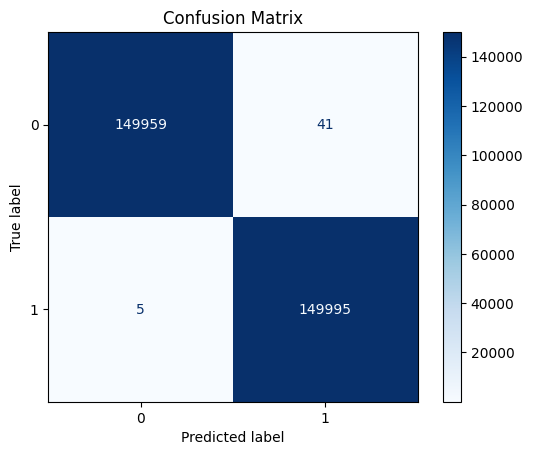

In [23]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

Computing training curves...


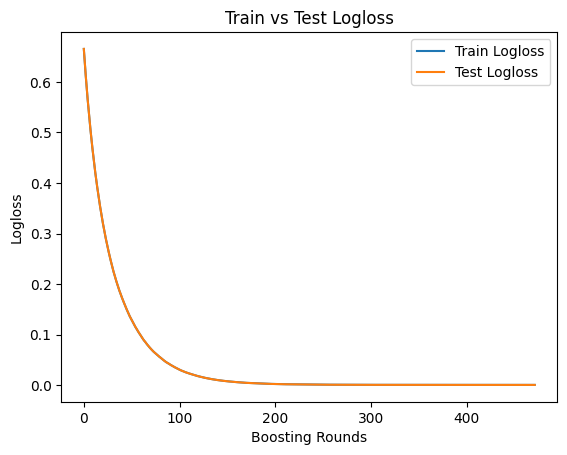

In [24]:
print("Computing training curves...")

eval_set = [(X_train, y_train), (X_test, y_test)]

best_model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=False
)

results = best_model.evals_result()

plt.figure()
plt.plot(results['validation_0']['logloss'], label="Train Logloss")
plt.plot(results['validation_1']['logloss'], label="Test Logloss")
plt.title("Train vs Test Logloss")
plt.xlabel("Boosting Rounds")
plt.ylabel("Logloss")
plt.legend()
plt.show()

#### Result
The evaluation of the XGBoost model shows outstanding performance, achieving an accuracy of 0.9998, a precision of 0.9997, a recall of 1.0000, and an F1 score of 0.9998. The classification report confirms these results, with both classes achieving perfect precision, recall, and F1 scores across all 300,000 samples. This demonstrates that XGBoost performs even slightly better than the previously tested MLP model. The next step is to further reduce model complexity in order to improve interpretability, and we will now explore the use of Decision Trees to achieve this goal.

### Decision Tree
Decision Trees are a type of supervised learning algorithm used for both classification and regression tasks. They work by recursively splitting the dataset into subsets based on the values of input features, creating a tree-like structure of nodes where each internal node represents a decision on a feature, each branch represents the outcome of that decision, and each leaf node represents a final prediction. One of the main advantages of Decision Trees is their interpretability: the model is highly explainable, and it is possible to directly extract human-readable rules from the tree, which can be very practical for understanding and communicating the decision process.

In [25]:
X_train_manual_feature = X_train[["Bwd Pkt Len Min", "ACK Flag Cnt", "Fwd Pkt Len Max", "Flow Pkts/s", "Fwd Pkts/s", "Init Bwd Win Byts", "Init Fwd Win Byts", "Flow Duration" ]]
X_test_manual_feature = X_test[["Bwd Pkt Len Min", "ACK Flag Cnt", "Fwd Pkt Len Max", "Flow Pkts/s", "Fwd Pkts/s", "Init Bwd Win Byts", "Init Fwd Win Byts", "Flow Duration"  ]]

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [3,5],
    'min_samples_split': [None, 2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

dt = DecisionTreeClassifier(random_state=42)

grid = GridSearchCV(
    dt,
    param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_manual_feature, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)

best_dt = grid.best_estimator_


Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score: 0.9815997972325257


#### Explanation of the Code: Decision Tree
The code selects a subset of manually chosen features from the training and test datasets for use with a Decision Tree classifier. A parameter grid is then defined, specifying different options for tree criteria, maximum depth, minimum samples required to split a node, minimum samples per leaf, and the number of features to consider at each split. A DecisionTreeClassifier is initialized, and a GridSearchCV is set up to perform an exhaustive search over all combinations of the hyperparameters using 5-fold cross-validation, optimizing for the macro F1 score.


Performance metrics:
Accuracy:  0.9813
Precision: 0.9784
Recall:    0.9845
F1 Score:  0.9814

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    150000
           1       0.98      0.98      0.98    150000

    accuracy                           0.98    300000
   macro avg       0.98      0.98      0.98    300000
weighted avg       0.98      0.98      0.98    300000



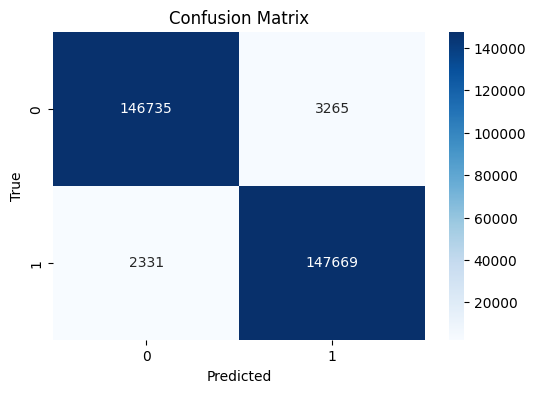

In [26]:
y_pred = best_dt.predict(X_test_manual_feature)

accuracy_dt = accuracy_score(y_test, y_pred)
precision_dt = precision_score(y_test, y_pred)
recall_dt = recall_score(y_test, y_pred)
f1_dt = f1_score(y_test, y_pred)


print("\nPerformance metrics:")
print(f"Accuracy:  {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall:    {recall_dt:.4f}")
print(f"F1 Score:  {f1_dt:.4f}")
print()
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#### Result
The evaluation of the Decision Tree model shows strong performance, with an accuracy of 0.9813, a precision of 0.9784, a recall of 0.9845, and an F1 score of 0.9814. The classification report confirms that both classes are predicted with very similar precision and recall, around 0.98 each, across all samples. While these results are slightly lower than those achieved by the CNN, MLP, and XGBoost models, the main advantage of the Decision Tree is its high interpretability. This makes it possible to directly examine the structure of the tree and extract human-readable rules or patterns. The next step is therefore to analyze the trained tree in detail to identify interpretable decision rules and gain insights into the underlying patterns in the data.

#### Interpretation and Rule Extraction from the Decision Tree

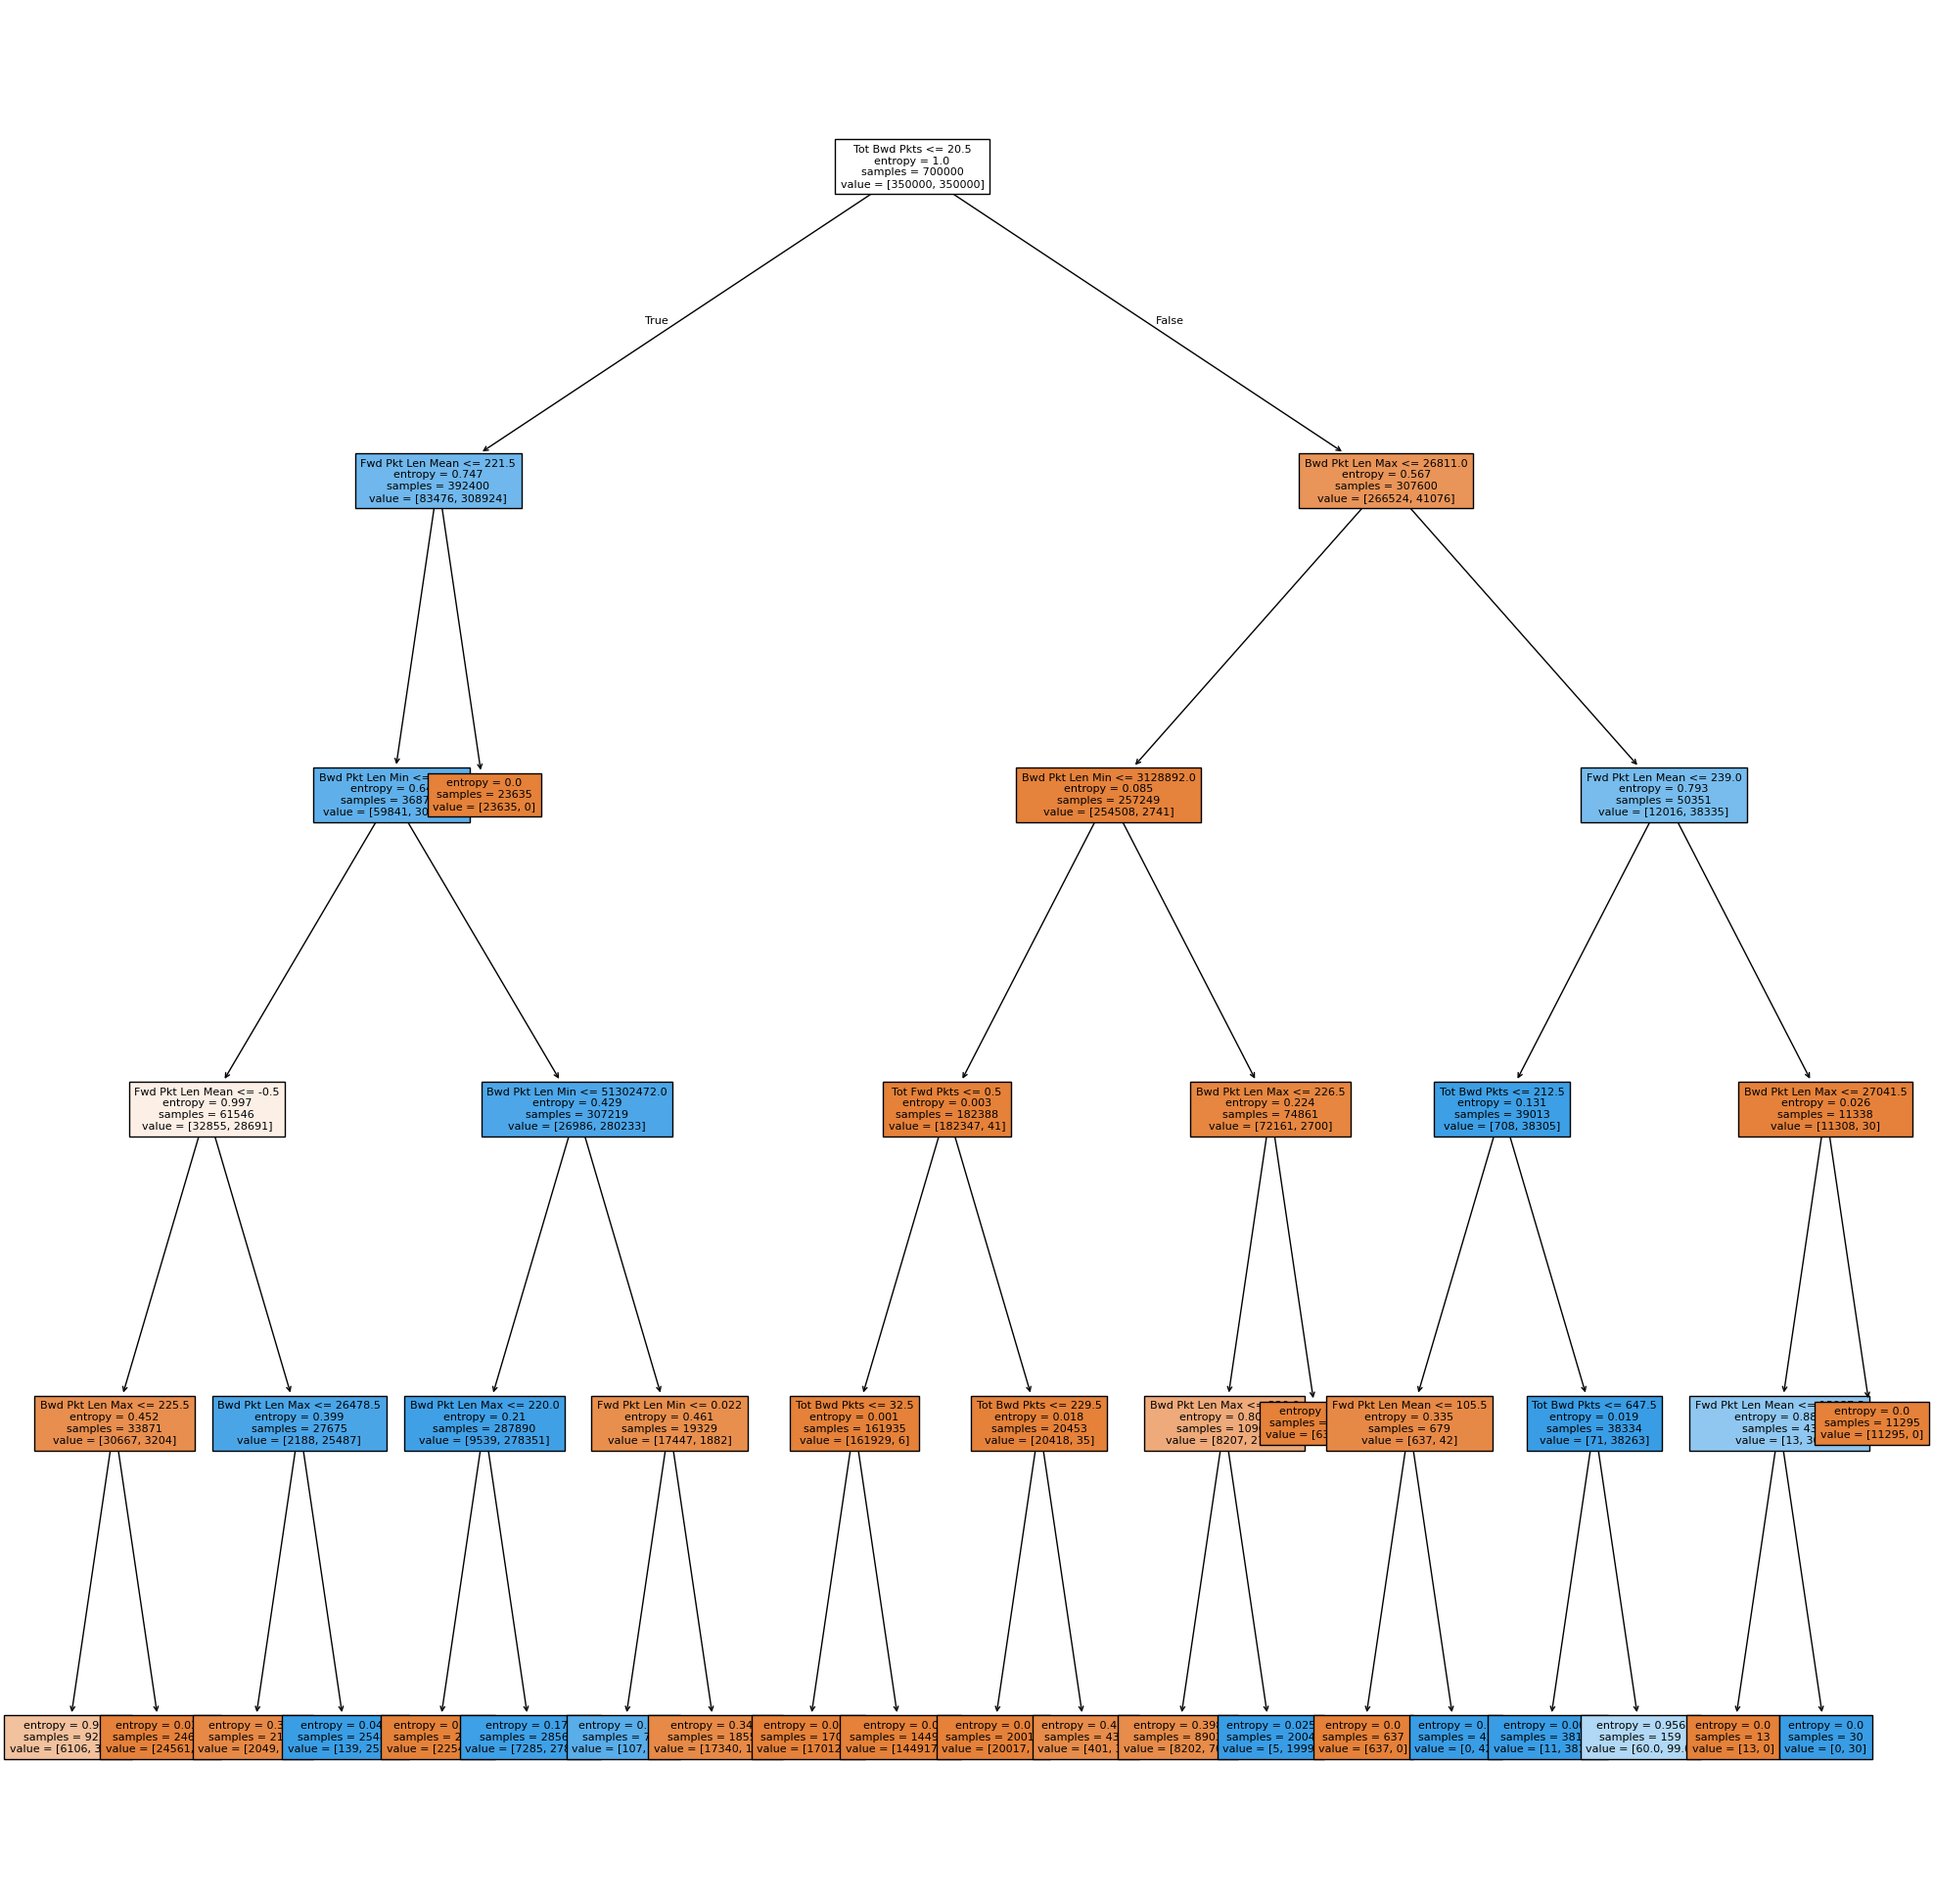

In [27]:
plt.figure(figsize=(25, 25))
plot_tree(
    best_dt,
    feature_names=X.columns,
    filled=True,
    fontsize=8
)
plt.show()

In [28]:
def extract_rules(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []

    def recurse(node, rule):
        if tree_.feature[node] == _tree.TREE_UNDEFINED:
            samples = tree_.n_node_samples[node]
            value = tree_.value[node][0]
            predicted_class = np.argmax(value)
            purity = value[predicted_class] / np.sum(value)  # fraction of samples in dominant class
            paths.append((rule.copy(), samples, predicted_class, purity))
            return

        name = feature_name[node]
        threshold = tree_.threshold[node]

        rule.append(f"{name} <= {threshold:.3f}")
        recurse(tree_.children_left[node], rule)
        rule.pop()

        rule.append(f"{name} > {threshold:.3f}")
        recurse(tree_.children_right[node], rule)
        rule.pop()

    recurse(0, [])
    return paths

rules = extract_rules(best_dt, X.columns)

print("\n=== EXTRACTED RULES ===\n")

rules_sorted = sorted(rules, key=lambda x: -x[1])

for rule, samples, pred_class, purity in rules_sorted:
    print("IF")
    for r in rule:
        print("   ", r)
    print(f"THEN class = {pred_class}   (covered samples: {samples}, purity: {purity:.3f})\n")



=== EXTRACTED RULES ===

IF
    Tot Bwd Pkts <= 20.500
    Fwd Pkt Len Mean <= 221.500
    Bwd Pkt Len Min > 313.500
    Bwd Pkt Len Min <= 51302472.000
    Bwd Pkt Len Max > 220.000
THEN class = 1   (covered samples: 285620, purity: 0.974)

IF
    Tot Bwd Pkts > 20.500
    Bwd Pkt Len Max <= 26811.000
    Bwd Pkt Len Min <= 3128892.000
    Tot Fwd Pkts <= 0.500
    Tot Bwd Pkts > 32.500
THEN class = 0   (covered samples: 144918, purity: 1.000)

IF
    Tot Bwd Pkts > 20.500
    Bwd Pkt Len Max <= 26811.000
    Bwd Pkt Len Min > 3128892.000
    Bwd Pkt Len Max > 226.500
THEN class = 0   (covered samples: 63954, purity: 1.000)

IF
    Tot Bwd Pkts > 20.500
    Bwd Pkt Len Max > 26811.000
    Fwd Pkt Len Mean <= 239.000
    Tot Bwd Pkts > 212.500
    Tot Bwd Pkts <= 647.500
THEN class = 1   (covered samples: 38175, purity: 1.000)

IF
    Tot Bwd Pkts <= 20.500
    Fwd Pkt Len Mean <= 221.500
    Bwd Pkt Len Min <= 313.500
    Fwd Pkt Len Mean > -0.500
    Bwd Pkt Len Max > 26478.500
THEN

### Detailed Interpretation of Key Decision Tree Rules for DOS Detection

The Decision Tree identifies patterns in network flows that distinguish **DOS attacks (class = 1)** from **normal traffic (class = 0)**. We focus on the six rules covering the largest number of samples, as they have the most influence on the classification.

---

#### 1. Rule 1 (Class = 1, covered samples: 285,620, high purity)

```code
IF Tot Bwd Pkts <= 20.500
    Fwd Pkt Len Mean <= 221.500
    Bwd Pkt Len Min > 313.500
    Bwd Pkt Len Min <= 51,302,472.000
    Bwd Pkt Len Max > 220.000
    THEN class = 1
```

- **Feature explanation:**
  - `Tot Bwd Pkts`: Total packets sent in the backward direction (from server to client).
  - `Fwd Pkt Len Mean`: Average size of forward packets (from client to server).
  - `Bwd Pkt Len Min` / `Bwd Pkt Len Max`: Minimum and maximum packet sizes in the backward direction.

- **Traffic pattern captured:**
  - Few backward packets (`<= 20`) indicate that the server responds minimally to the flow.
  - Small forward packet sizes suggest that the attacker is sending many small packets, typical for flooding attacks.
  - Moderate backward packet sizes indicate that occasional server responses exist but are insufficient to handle the load.

- **Interpretation:**
  - This rule captures classic DOS behavior: asymmetric traffic with many small attacker packets and very few server responses.
  - High purity implies that almost all flows satisfying this rule are indeed DOS attacks.

---

#### 2. Rule 2 (Class = 0, covered samples: 144,918)
```code
IF Tot Bwd Pkts > 20.500
    Bwd Pkt Len Max <= 26,811.000
    Bwd Pkt Len Min <= 3,128,892.000
    Tot Fwd Pkts <= 0.500
    Tot Bwd Pkts > 32.500
THEN class = 0
```

- **Feature explanation:**
  - `Tot Fwd Pkts <= 0.5` indicates very few forward packets.
  - `Tot Bwd Pkts > 32.5` indicates many backward packets.
  - Moderate backward packet sizes (`Bwd Pkt Len Min/Max`) suggest normal server responses.

- **Traffic pattern captured:**
  - Normal flows often involve the server sending responses while clients send very few packets.
  - Balanced communication with moderate packet sizes is typical of legitimate client-server interactions (e.g., web browsing or database queries).

- **Interpretation:**
  - This rule identifies normal traffic, characterized by more backward packets than forward packets and a stable response pattern.

---

#### 3. Rule 3 (Class = 1, covered samples: 38,175)
```code
IF Tot Bwd Pkts > 20.500
Bwd Pkt Len Max > 26,811.000
Fwd Pkt Len Mean <= 239.000
Tot Bwd Pkts > 212.500
Tot Bwd Pkts <= 647.500
THEN class = 1
```

- **Traffic pattern captured:**
  - Very high backward packet counts indicate that the server is overwhelmed, sending many packets in response.
  - Forward packet sizes are small and consistent (`<= 239`), showing flood-like behavior by the attacker.
  - This asymmetry and extreme backward traffic are indicative of a flooding DOS attack.

- **Interpretation:**
  - The server struggles to respond to numerous small attack packets, producing a burst of backward packets.
  - This is a secondary DOS signature, complementing Rule 1, but focused on flows where the server’s response volume is extremely high.

---

#### 4. Rule 4 (Class = 1, covered samples: 25,489)
```code
IF Tot Bwd Pkts <= 20.500
    Fwd Pkt Len Mean <= 221.500
    Bwd Pkt Len Min <= 313.500
    Fwd Pkt Len Mean > -0.500
    Bwd Pkt Len Max > 26,478.500
THEN class = 1
```

- **Traffic pattern captured:**
  - Few backward packets indicate limited server responses.
  - Small average forward packet size indicates high-frequency attack packets.
  - Large maximum backward packet size indicates occasional server bursts trying to respond.

- **Interpretation:**
  - This rule detects targeted DOS attempts, where the attacker floods the server with small packets while the server occasionally responds with larger packets.
  - The combination of few backward packets and high variance in server responses is typical of attempts to overwhelm the system.

---

#### 5. Rule 5 (Class = 0, covered samples: 23,635)
```code
IF Tot Bwd Pkts <= 20.500
    Fwd Pkt Len Mean > 221.500
THEN class = 0
```

- **Traffic pattern captured:**
  - Few backward packets, but larger average forward packet lengths indicate legitimate large data transfers.
  - Server responses may be limited but flow characteristics are **consistent with normal traffic**.

- **Interpretation:**
  - This rule identifies **normal traffic with large packets**, such as file uploads or downloads, distinguishing it from DOS attacks, which involve small, frequent packets.


### Summary of Patterns

From these six rules, we can identify **two major traffic types**:

1. **DOS attacks (class = 1):**
   - Few backward packets relative to forward packets.
   - Small, uniform forward packet sizes.
   - Occasional bursts or extreme sizes in backward packets caused by server overload.

2. **Normal traffic (class = 0):**
   - Balanced forward and backward packets.
   - Larger or variable forward packet sizes.
   - Moderate backward packet sizes reflecting regular client-server interaction.




## Conclusion

=== Comparison Table ===
           Model  Accuracy  Precision    Recall  F1 Score
0            CNN  0.995157   0.993718  0.996613  0.995164
1            MLP  0.995190   0.995418  0.994960  0.995189
2        XGBoost  0.999847   0.999727  0.999967  0.999847
3  Decision Tree  0.981347   0.978368  0.984460  0.981405


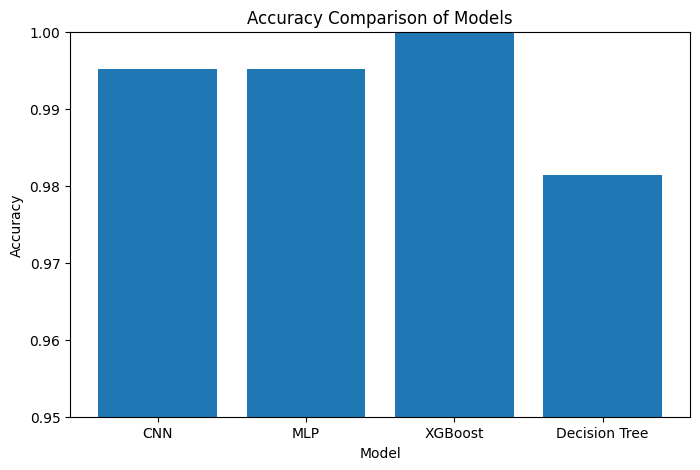

In [29]:
results_df = pd.DataFrame({
    "Model": ["CNN", "MLP", "XGBoost", "Decision Tree"],
    "Accuracy": [accuracy_cnn, accuracy_mlp, accuracy_xgboost, accuracy_dt],
    "Precision": [precision_cnn, precision_mlp, precision_xgboost, precision_dt],
    "Recall": [recall_cnn, recall_mlp, recall_xgboost, recall_dt],
    "F1 Score": [f1_cnn, f1_mlp, f1_xgboost, f1_dt]
})

print("=== Comparison Table ===")
print(results_df)

plt.rcParams["figure.figsize"] = (8, 5)

plt.bar(
    ["CNN", "MLP", "XGBoost", "Decision Tree"],
    [accuracy_cnn, accuracy_mlp, accuracy_xgboost, accuracy_dt]
)

plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison of Models")
plt.ylim(0.95, 1.0)
plt.show()


### Comparison of the Models
The four models CNN, MLP, XGBoost, and Decision Tree all demonstrate very strong performance but differ in terms of peak accuracy and overall stability. XGBoost clearly outperforms the others, achieving near-perfect values for Accuracy, Precision, Recall, and F1 Score, all approximately 0.9998, indicating an extremely effective and robust classification. CNN and MLP also perform exceptionally well and are very close to each other, with CNN having a slight advantage in Recall, 0.9966, and MLP showing a slightly higher Precision, 0.9954, making it the most balanced among the two. The Decision Tree ranks lowest, achieving respectable metrics but noticeably below the other models, particularly in Accuracy, 0.9813. Overall, while more complex models like XGBoost deliver superior performance, the Decision Tree provides simplicity and interpretability at the cost of reduced performance.

### Key Insights
In this project, we observed that it is not always advisable to begin with the most complex model. Particularly in critical environments such as Intrusion Detection Systems (IDS) within companies, relying on opaque black-box architectures can introduce significant challenges. Security-driven decisions require a high degree of transparency, as system operators must be able to understand and justify why certain network traffic is classified as malicious or permitted. For this reason, simpler and more interpretable models such as decision trees remain highly valuable. They enable the extraction of human-readable rules that offer clear explanations for the model’s behavior, strengthen trust in the system, and support informed decision-making.

### Future Work
Future work could focus on developing and evaluating a DDoS/DoS detection system on non-commuted, real-world network traffic. This would make it possible to assess how well the machine-learning–based approach performs under realistic operational conditions compared to traditional rule-based detection methods. Such an evaluation would provide valuable insights into the robustness and generalizability of the models and help determine whether data-driven techniques can reliably outperform manually engineered rules in practical enterprise environments.